In [1]:
import pandas as pd
import numpy as np
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

## load Data

In [2]:
data = pd.read_csv("analysisData.csv")

/Users/leafan/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3165: DtypeWarning: Columns (31,79,80) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


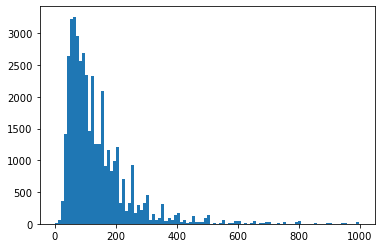

In [3]:
plt.hist(data.price, bins=100);

## Drop useless features

In [4]:
data = data.drop(columns=['name', 'summary','description','neighborhood_overview',
       'notes','house_rules', 'host_name',
       'host_since', 'host_location', 'host_about','host_neighbourhood','country_code',
       'country','jurisdiction_names','neighbourhood_cleansed','neighbourhood','street','city','zipcode','market','smart_location',
       'calendar_updated','first_review','last_review','license','state'])

## Data cleaning

In [5]:
selected_f = ['accommodates', 
              'bathrooms', 
              'bedrooms', 
              'beds', 
              'square_feet', 
              'security_deposit', 
              'cleaning_fee',
              'guests_included', 
              'weekly_price',
              'amenities',
              'host_verifications',
              'host_response_rate',
              'host_acceptance_rate']
cate = ['neighbourhood_group_cleansed','host_response_time',
#         'property_type',
        'room_type','bed_type','cancellation_policy']
nan_or_not = ['space','transit','access','interaction']

In [6]:
selected_f = selected_f + nan_or_not + cate

In [7]:
data = data[['price']+selected_f]

In [8]:
data.loc[:,'amenities'] = data['amenities'].map(lambda x:len(x.split(',')))
data.loc[:,'host_verifications'] = data['host_verifications'].apply(lambda x:len(x))

for col in data.columns:
    data[col] = data[col].map(lambda x:1 if x == 't' else (0 if x == 'f' else x))

data['host_response_rate'] = data['host_response_rate'].map(lambda x:int(str(x)[:-1]) if type(x) ==str and '%' in x else x)

data['host_acceptance_rate'] = data['host_acceptance_rate'].map(lambda x:int(str(x)[:-1]) if type(x) ==str and '%' in x else x)

for feature in nan_or_not:
    data.loc[:,feature] = data[feature].fillna('nan')
    data.loc[:,feature] = data[feature].apply(lambda x:0 if str(x) == 'nan' else 1)

data = pd.get_dummies(data=data)

for col in data.columns:
    data[col].fillna(data[col].mean(),inplace = True)

## Building models

In [9]:
ddf = data.copy()

In [20]:
X = ddf.iloc[:,:]  #independent columns
y = ddf.loc[:,'price']    #target column i.e price range
#apply SelectKBest class to extract top 10 best features
bestfeatures = SelectKBest(score_func=chi2, k=10)
fit = bestfeatures.fit(X,y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)
#concat two dataframes for better visualization 
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Specs','Score']  #naming the dataframe columns
print(featureScores.nlargest(10,'Score'))  #print 10 best features

                        Specs         Score
0                       price  3.721035e+06
7                cleaning_fee  5.295454e+05
6            security_deposit  5.294021e+05
1                accommodates  1.880577e+04
9                weekly_price  1.349448e+04
10                  amenities  1.039672e+04
11         host_verifications  1.038474e+04
62     room_type_Private room  1.027389e+04
60  room_type_Entire home/apt  1.002646e+04
53       property_type_Resort  9.463211e+03


[0.30690232 0.03794881 0.02143015 0.0238637  0.03604545 0.00312563
 0.05960939 0.08294912 0.02887659 0.01760949 0.09875169 0.09091907
 0.05636021 0.07285321 0.01047438 0.01510323 0.0140917  0.01535928
 0.00175332 0.00597327]


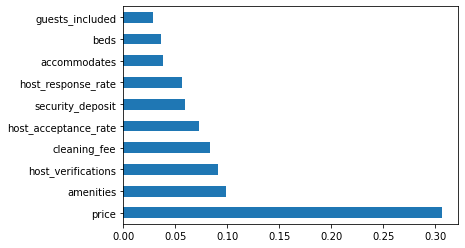

In [21]:
X = ddf.iloc[:,:20]  #independent columns
y = ddf.loc[:,'price']    #target column i.e price range
from sklearn.ensemble import ExtraTreesClassifier
import matplotlib.pyplot as plt
model = ExtraTreesClassifier()
model.fit(X,y)
print(model.feature_importances_) #use inbuilt class feature_importances of tree based classifiers
#plot graph of feature importances for better visualization
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(10).plot(kind='barh')
plt.show()

<AxesSubplot:>

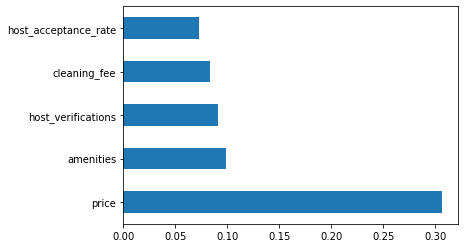

In [22]:
feat_importances.nlargest(5).plot(kind='barh')


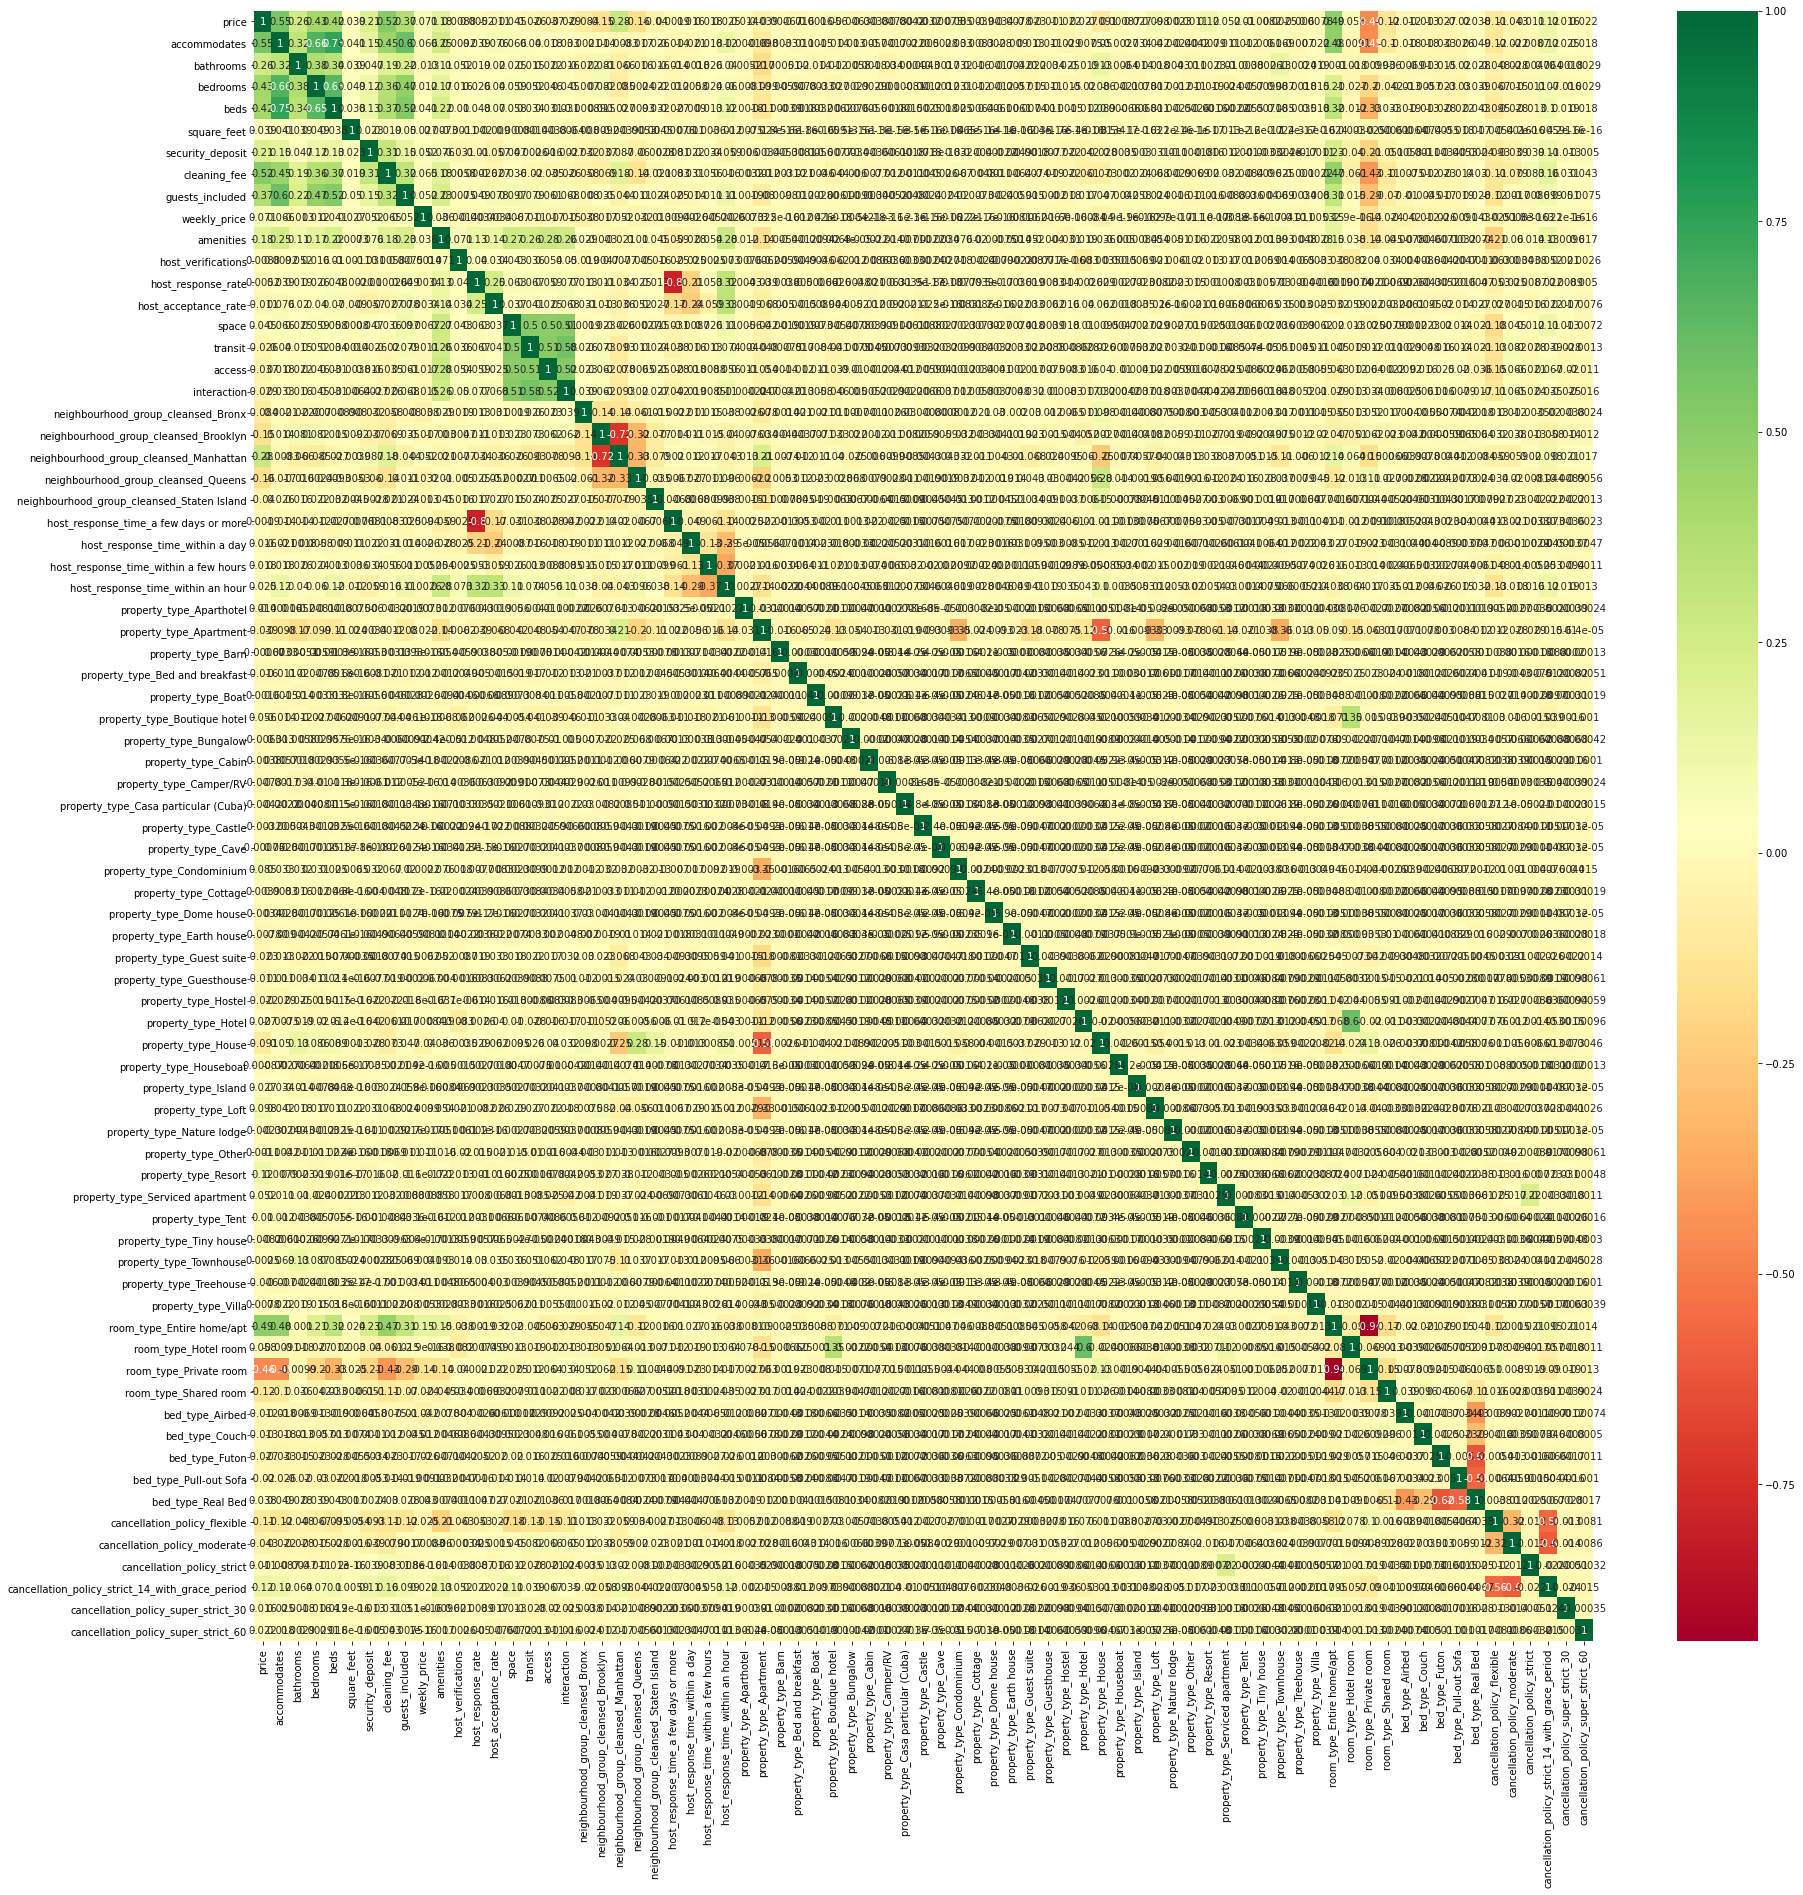

In [23]:
# X = ddf.iloc[:,21:50]  #independent columns
# y = ddf.loc[:,'price']    #target column i.e price range
#get correlations of each features in dataset
corrmat = data.corr()
top_corr_features = corrmat.index
plt.figure(figsize=(30,30))
#plot heat map
g=sns.heatmap(data[top_corr_features].corr(),annot=True,cmap="RdYlGn")

## remove outliers

/Users/leafan/opt/anaconda3/lib/python3.8/site-packages/pandas/plotting/_matplotlib/core.py:337: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


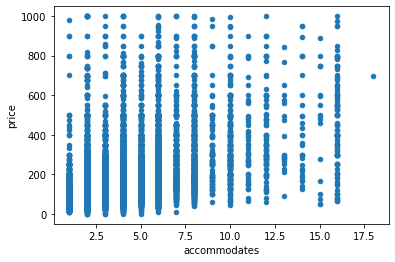

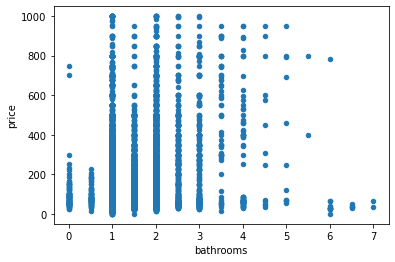

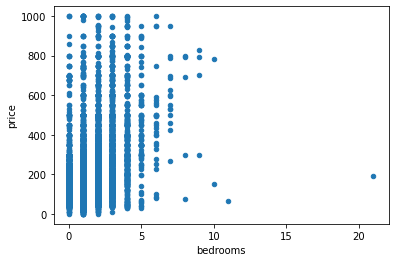

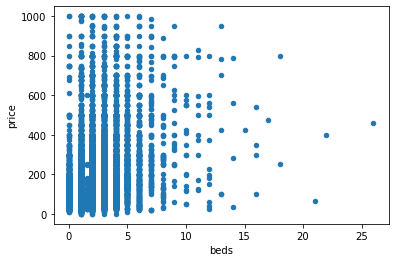

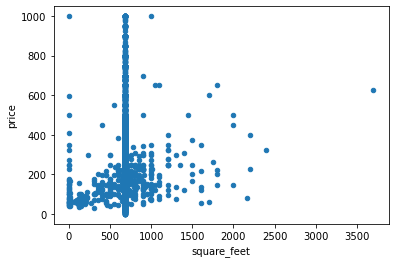

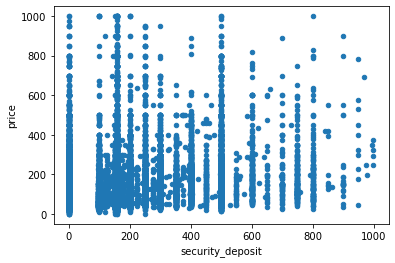

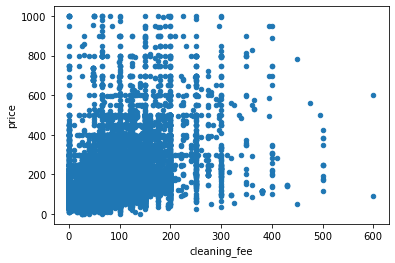

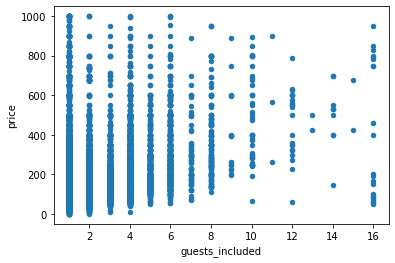

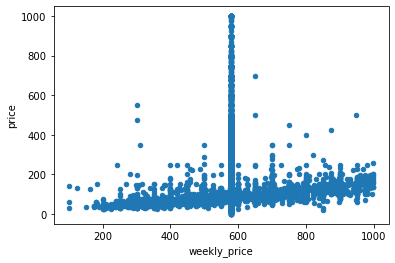

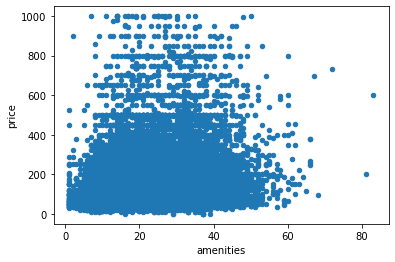

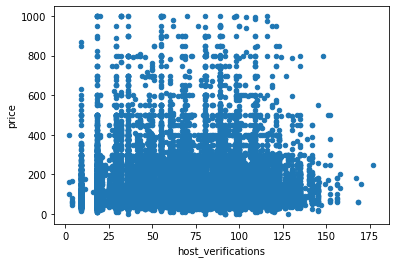

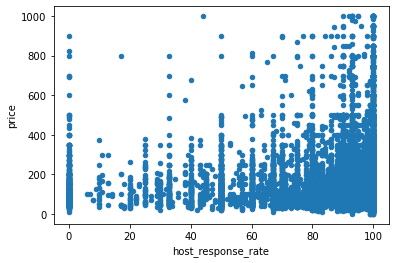

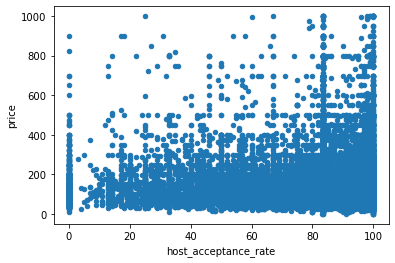

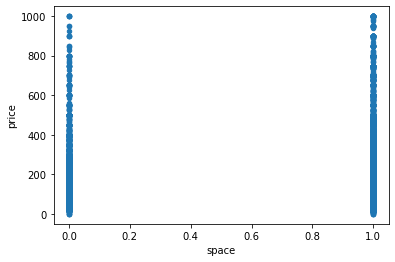

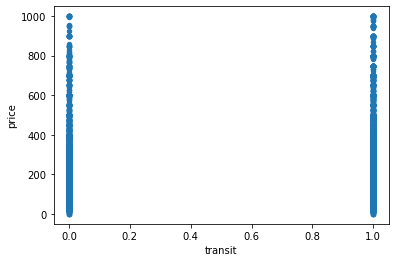

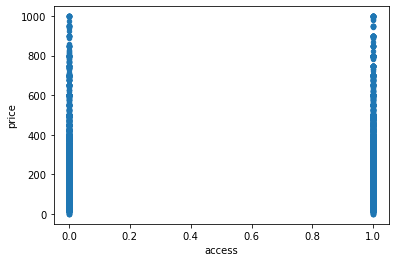

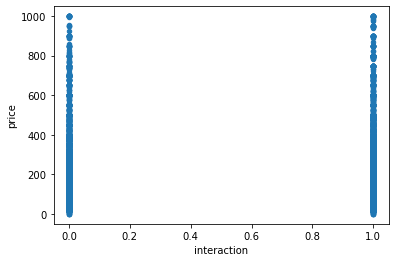

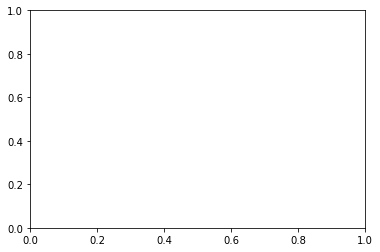

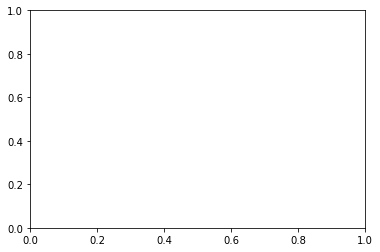

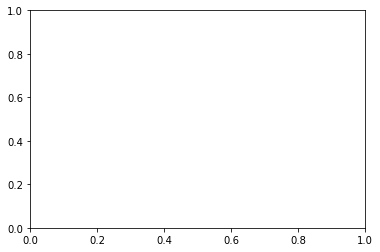

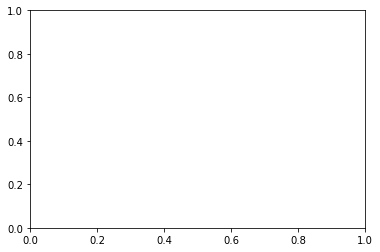

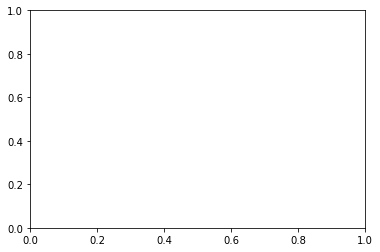

In [10]:
for feature in selected_f:
    try:
        ddf.plot.scatter(feature, 'price')
    except:
        continue

In [11]:
ddf = data.copy()

In [12]:
def remove_outliers(train_df, feature, low_value, high_value):
    print(feature, ': ', train_df.shape)
    train_df = train_df[train_df[feature]>=low_value]
    train_df = train_df[train_df[feature]<=high_value]
    train_df.reset_index(drop=True,inplace=True)
    print(feature, ': ', train_df.shape)
    return train_df

ddf = remove_outliers(ddf, 'price', 0, 600)
ddf = remove_outliers(ddf, 'accommodates', 0, 17)
ddf = remove_outliers(ddf, 'bathrooms', 0, 5)
ddf = remove_outliers(ddf, 'bedrooms', 0, 7)
ddf = remove_outliers(ddf, 'beds', 0, 15)
ddf = remove_outliers(ddf, 'square_feet', 0, 2000)
ddf = remove_outliers(ddf, 'cleaning_fee', 0, 400)
ddf = remove_outliers(ddf, 'amenities', 0, 70)
ddf = remove_outliers(ddf, 'host_verifications', 0, 150)
ddf = remove_outliers(ddf, 'host_response_rate', 1, 100)
ddf = remove_outliers(ddf, 'host_acceptance_rate', 1, 100)

price :  (41330, 42)
price :  (40941, 42)
accommodates :  (40941, 42)
accommodates :  (40941, 42)
bathrooms :  (40941, 42)
bathrooms :  (40922, 42)
bedrooms :  (40922, 42)
bedrooms :  (40916, 42)
beds :  (40916, 42)
beds :  (40909, 42)
square_feet :  (40909, 42)
square_feet :  (40905, 42)
cleaning_fee :  (40905, 42)
cleaning_fee :  (40885, 42)
amenities :  (40885, 42)
amenities :  (40883, 42)
host_verifications :  (40883, 42)
host_verifications :  (40856, 42)
host_response_rate :  (40856, 42)
host_response_rate :  (40412, 42)
host_acceptance_rate :  (40412, 42)
host_acceptance_rate :  (39856, 42)


In [13]:
select_df = ddf

In [14]:
select_df.columns

Index(['price', 'accommodates', 'bathrooms', 'bedrooms', 'beds', 'square_feet',
       'security_deposit', 'cleaning_fee', 'guests_included', 'weekly_price',
       'amenities', 'host_verifications', 'host_response_rate',
       'host_acceptance_rate', 'space', 'transit', 'access', 'interaction',
       'neighbourhood_group_cleansed_Bronx',
       'neighbourhood_group_cleansed_Brooklyn',
       'neighbourhood_group_cleansed_Manhattan',
       'neighbourhood_group_cleansed_Queens',
       'neighbourhood_group_cleansed_Staten Island',
       'host_response_time_a few days or more',
       'host_response_time_within a day',
       'host_response_time_within a few hours',
       'host_response_time_within an hour', 'room_type_Entire home/apt',
       'room_type_Hotel room', 'room_type_Private room',
       'room_type_Shared room', 'bed_type_Airbed', 'bed_type_Couch',
       'bed_type_Futon', 'bed_type_Pull-out Sofa', 'bed_type_Real Bed',
       'cancellation_policy_flexible', 'cancellation

In [15]:
from sklearn.preprocessing import StandardScaler

#separate the other attributes from the predicting attribute
x = select_df.drop(columns='price')
ss = StandardScaler()
x.iloc[:,:] = ss.fit_transform(x.iloc[:,:])
#separte the predicting attribute into Y for model training 
y = select_df['price']

In [16]:
# importing train_test_split from sklearn
from sklearn.model_selection import train_test_split
# splitting the data
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.7)

GradientBoost

In [17]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

GB = GradientBoostingRegressor(
    max_depth=4,
    n_estimators=100,
    alpha = 0.1
)
GB.fit(x_train,y_train)
y_pred_dtr_GB = GB.predict(x_test)

In [18]:
# importing r2_score module
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
# predicting the accuracy score
score=r2_score(y_test,y_pred_dtr_GB)
print('r2 socre is' ,score)
print('mean_sqrd_error is==',mean_squared_error(y_test,y_pred_dtr_GB))
print('root_mean_squared error of is==',np.sqrt(mean_squared_error(y_test,y_pred_dtr_GB)))

r2 socre is 0.5976941502914259
mean_sqrd_error is== 3342.2175953829706
root_mean_squared error of is== 57.81191568684583


In [19]:
print(GB.score(x_train,y_train))
print(GB.score(x_test,y_test))


0.6571567574126584
0.5976941502914259


decision Tree reg

In [36]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

regressor = DecisionTreeRegressor(random_state = 1)
std_slc = StandardScaler()
dtr_model = Pipeline(steps=[('All',std_slc),('regressor',regressor)])
dtr_model.fit(x_train,y_train)
y_pred_dtr = dtr_model.predict(x_test)

In [37]:
# importing r2_score module
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
# predicting the accuracy score
score=r2_score(y_test,y_pred_dtr)
print('r2 socre is' ,score)
print('mean_sqrd_error is==',mean_squared_error(y_test,y_pred_dtr))
print('root_mean_squared error of is==',np.sqrt(mean_squared_error(y_test,y_pred_dtr)))

r2 socre is 0.17964181340030605
mean_sqrd_error is== 10005.398312090194
root_mean_squared error of is== 100.0269879187122


ploynomial reg

In [30]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline

polynomial_features = PolynomialFeatures(degree = 2)
plRegressor = LinearRegression()
pl_model = Pipeline(steps=[('poly_f',polynomial_features),('regressor',plRegressor)])
pl_model.fit(x_train,y_train)
y_pred = pl_model.predict(x_test)

In [31]:
# importing r2_score module
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
# predicting the accuracy score
score=r2_score(y_test,y_pred)
print('r2 socre is' ,score)
print('mean_sqrd_error is==',mean_squared_error(y_test,y_pred))
print('root_mean_squared error of is==',np.sqrt(mean_squared_error(y_test,y_pred)))

r2 socre is -3.8134470614461573e+18
mean_sqrd_error is== 4.651024078882877e+22
root_mean_squared error of is== 215662330481.77136


LinearRegression

In [32]:
# importing module
from sklearn.linear_model import LinearRegression
# creating an object of LinearRegression class
LR = LinearRegression()
# fitting the training data
LR.fit(x_train,y_train)

LinearRegression()

In [33]:
y_prediction =  LR.predict(x_test)
y_prediction

array([154.05581665,  46.31411743, 167.55114746, ..., 358.54605103,
        91.44448853,  87.86022949])

In [34]:
# importing r2_score module
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
# predicting the accuracy score
score=r2_score(y_test,y_prediction)
print('r2 socre is' ,score)
print('mean_sqrd_error is==',mean_squared_error(y_test,y_prediction))
print('root_mean_squared error of is==',np.sqrt(mean_squared_error(y_test,y_prediction)))

r2 socre is -2.977111988039891e+23
mean_sqrd_error is== 3.630998233040479e+27
root_mean_squared error of is== 60257764919058.19


## Use selected model for prediction

In [32]:
score_df = pd.read_csv('scoringData.csv')

In [33]:
scoring_df = score_df.copy()

In [34]:
scoring_df = scoring_df[selected_f]

scoring_df.loc[:,'amenities'] = scoring_df['amenities'].map(lambda x:len(x.split(',')))
scoring_df.loc[:,'host_verifications'] = scoring_df['host_verifications'].apply(lambda x:len(x))

for col in scoring_df.columns:
    scoring_df[col] = scoring_df[col].map(lambda x:1 if x == 't' else (0 if x == 'f' else x))

scoring_df['host_response_rate'] = scoring_df['host_response_rate'].map(lambda x:int(str(x)[:-1]) if type(x) ==str and '%' in x else x)

scoring_df['host_acceptance_rate'] = scoring_df['host_acceptance_rate'].map(lambda x:int(str(x)[:-1]) if type(x) ==str and '%' in x else x)

for feature in nan_or_not:
    scoring_df.loc[:,feature] = scoring_df[feature].fillna('nan')
    scoring_df.loc[:,feature] = scoring_df[feature].apply(lambda x:0 if str(x) == 'nan' else 1)

scoring_df = pd.get_dummies(data=scoring_df)

for col in scoring_df.columns:
    scoring_df[col].fillna(scoring_df[col].mean(),inplace = True)

In [36]:
non_exist_features = list(set(ddf.columns)-set(scoring_df.columns))

In [37]:
non_exist_features.remove('price')

In [38]:
for col in non_exist_features:
    scoring_df.loc[:,col] = 0

In [40]:
set(scoring_df.columns)-set(ddf.columns)

{'property_type_Lighthouse', 'property_type_Timeshare'}

In [23]:
scoring_df.columns

Index(['accommodates', 'bathrooms', 'bedrooms', 'beds', 'square_feet',
       'security_deposit', 'cleaning_fee', 'guests_included', 'weekly_price',
       'amenities', 'host_verifications', 'host_response_rate',
       'host_acceptance_rate', 'space', 'transit', 'access', 'interaction',
       'neighbourhood_group_cleansed_Bronx',
       'neighbourhood_group_cleansed_Brooklyn',
       'neighbourhood_group_cleansed_Manhattan',
       'neighbourhood_group_cleansed_Queens',
       'neighbourhood_group_cleansed_Staten Island',
       'host_response_time_a few days or more',
       'host_response_time_within a day',
       'host_response_time_within a few hours',
       'host_response_time_within an hour', 'room_type_Entire home/apt',
       'room_type_Hotel room', 'room_type_Private room',
       'room_type_Shared room', 'bed_type_Airbed', 'bed_type_Couch',
       'bed_type_Futon', 'bed_type_Pull-out Sofa', 'bed_type_Real Bed',
       'cancellation_policy_flexible', 'cancellation_policy_m

In [35]:
ss = StandardScaler()
scoring_df.iloc[:,:] = ss.fit_transform(scoring_df.iloc[:,:])
price_prediction = GB.predict(scoring_df)

In [36]:
price_prediction

array([130.12321168,  83.7273866 ,  77.4084803 , ..., 169.74740584,
        70.90116961, 126.21178174])

In [37]:
res = pd.DataFrame({'id':score_df['id'],'price':price_prediction})

In [38]:
res

,id,price
0,10310,130.123212
1,10426,83.727387
2,10583,77.408480
3,10973,206.402768
4,11000,149.863528
...,...,...
10328,997437,322.948358
10329,997665,203.590295
10330,998046,169.747406
10331,998368,70.901170


In [39]:
res.to_csv('result.csv')